In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train['TAG']='TRAIN'
test['TAG']='TEST'
combined=pd.concat([train,test],sort=False)

In [0]:
#%autosave 60

# BASIC EXPLORATIONS

In [4]:
combined.shape

(273850, 15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

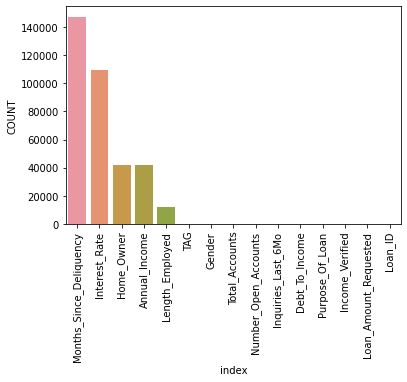

In [5]:
x=(combined.isnull().sum() * 100 / len(combined)).round(2).sort_values(ascending=False)
y=combined.isnull().sum().sort_values(ascending=False)
FR=pd.concat([x,y],axis=1,keys=['PRECENT','COUNT']).reset_index()
sns.barplot(FR['index'],FR['COUNT'])
plt.xticks(rotation=90)

In [6]:
combined.isnull().sum()

Loan_ID                         0
Loan_Amount_Requested           0
Length_Employed             12307
Home_Owner                  42060
Annual_Income               42000
Income_Verified                 0
Purpose_Of_Loan                 0
Debt_To_Income                  0
Inquiries_Last_6Mo              0
Months_Since_Deliquency    147238
Number_Open_Accounts            0
Total_Accounts                  0
Gender                          0
Interest_Rate              109541
TAG                             0
dtype: int64

In [7]:
combined.dtypes


Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate              float64
TAG                         object
dtype: object

In [0]:
# Loan_Amount_requested isn't in relevant datatype bucket.
combined.Loan_Amount_Requested=combined.Loan_Amount_Requested.str.replace(',', '').astype('int')


In [9]:
combined.describe()

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,2.738500e+05,273850.000000,2.318500e+05,273850.000000,273850.000000,126612.000000,273850.000000,273850.000000,164309.000000
mean,1.013693e+07,14352.992240,7.339279e+04,17.215901,0.784543,34.103395,11.186025,25.067975,2.158951
std,7.905383e+04,8289.036702,5.852984e+04,7.845967,1.036816,21.750307,4.973663,11.589677,0.738364
min,1.000000e+07,500.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.006846e+07,8000.000000,4.500000e+04,11.360000,0.000000,16.000000,8.000000,17.000000,2.000000
50%,1.013693e+07,12000.000000,6.300000e+04,16.850000,0.000000,31.000000,10.000000,23.000000,2.000000
75%,1.020539e+07,20000.000000,8.900000e+04,22.780000,1.000000,49.000000,14.000000,32.000000,3.000000
max,1.027385e+07,35000.000000,7.500000e+06,39.990000,8.000000,180.000000,84.000000,156.000000,3.000000


In [10]:
combined.describe(include='object')

,Length_Employed,Home_Owner,Income_Verified,Purpose_Of_Loan,Gender,TAG
count,261543,231790,273850,273850,273850,273850
unique,11,5,3,14,2,2
top,10+ years,Mortgage,VERIFIED - income,debt_consolidation,Male,TRAIN
freq,88328,117270,99076,161403,194993,164309


In [11]:
combined.nunique(axis=0)

Loan_ID                    273850
Loan_Amount_Requested        1320
Length_Employed                11
Home_Owner                      5
Annual_Income               18573
Income_Verified                 3
Purpose_Of_Loan                14
Debt_To_Income               3987
Inquiries_Last_6Mo              9
Months_Since_Deliquency       132
Number_Open_Accounts           61
Total_Accounts                103
Gender                          2
Interest_Rate                   3
TAG                             2
dtype: int64

In [12]:
combined.shape

(273850, 15)

# Distribution of the TARGET

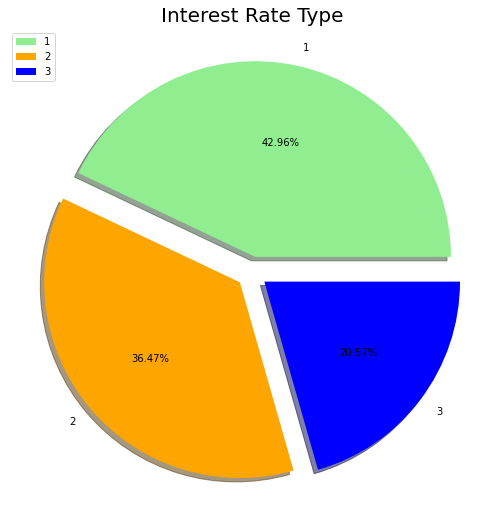

In [13]:
labels = ['1', '2','3']
size = train['Interest_Rate'].value_counts()
colors = ['lightgreen', 'orange','blue']
explode = [0.08, 0.08,0.08]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Interest Rate Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Categorical Variables

In [14]:
#Filter categorical variables
cat_columns = [x for x in combined.dtypes.index if combined.dtypes[x]=='object']
#Exclude :
cat_columns = [x for x in cat_columns if x not in ['Loan_ID','TAG']]
#Print frequency of categories
for col in cat_columns:
    print('\nFrequency of Categories for variable %s'%col)
    print(combined[col].value_counts())


Frequency of Categories for variable Length_Employed
10+ years    88328
2 years      24420
3 years      21478
< 1 year     21133
5 years      18042
1 year       17336
4 years      16393
7 years      15444
6 years      15351
8 years      13115
9 years      10503
Name: Length_Employed, dtype: int64

Frequency of Categories for variable Home_Owner
Mortgage    117270
Rent         93542
Own          20879
Other           79
None            20
Name: Home_Owner, dtype: int64

Frequency of Categories for variable Income_Verified
VERIFIED - income           99076
VERIFIED - income source    88253
not verified                86521
Name: Income_Verified, dtype: int64

Frequency of Categories for variable Purpose_Of_Loan
debt_consolidation    161403
credit_card            61394
home_improvement       15455
other                  13846
major_purchase          5712
small_business          4064
car                     3149
medical                 2633
moving                  1675
vacation           

# Observations

## Home_Owner:
We can merge 'Other','None', 'Unknown'(to be imputed for missing) together.

## Income Verified:  
looks like two of the dispositions ( VERIFIED income, VERIFIED income source needs to be merged)

## Purpose of loan
can be grouped on the following type of loans to reduce the levels

a)Education

b)Personal- Wedding, moving, major_purchase, home_improvement, vacation, medical

c)debt_consolidation

d)house

e)car

f)Other- renewable energy, other, small business loans

g)credit


In [0]:
# Numerical Variables

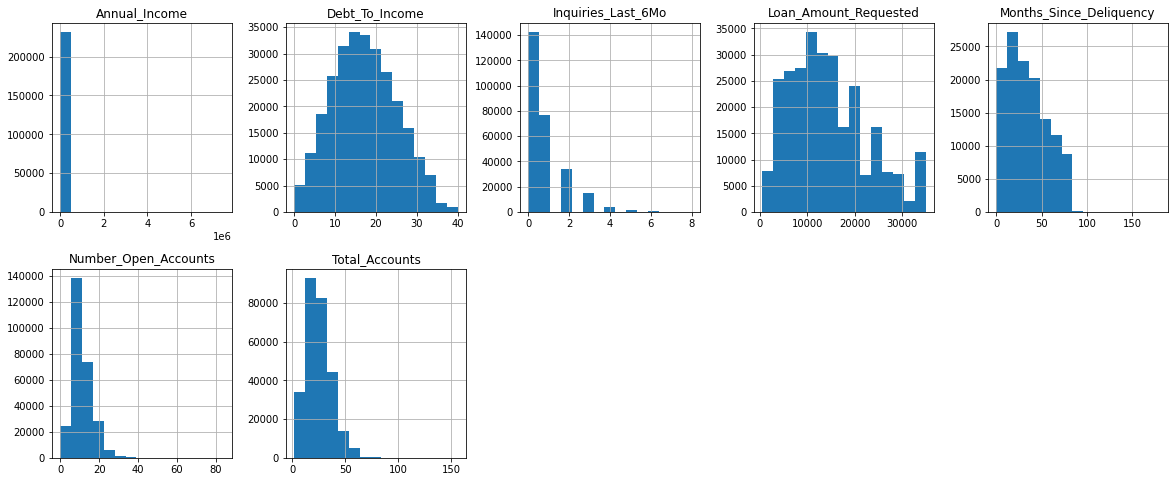

In [16]:
nums = [x for x in combined.dtypes.index if combined.dtypes[x]!='object']
#Exclude :
nums = [x for x in nums if x not in ['Loan_ID','Interest_Rate']]
combined[nums].hist(bins=15, figsize=(20, 8), layout=(2, 5));

# CLEANING/PRE_PROCESSING/FEATURE ENGINEERING STEP

In [0]:
# #PRE-PROCESSING/VARIABLE CLEANING BEFORE IMPUTATION/ FEATURE EXTRACTION

# #Home Owner
# combined['Home_Owner'] =  combined['Home_Owner'].replace({'Other':'Unknown','None':'Unknown'})

# # #Income Verified
# combined['Income_Verified'] =  combined['Income_Verified'].replace({'VERIFIED - income':'Verified','VERIFIED - income source':'Verified'})

# # #purpose of loan
# # l=['home_improvement','major_purchase', 'medical', 'moving','wedding', 'vacation']
# # o=['renewable_energy','other','small_business']
combined['Purpose_Of_Loan'] =  combined['Purpose_Of_Loan'].replace({'renewable_energy':'Others','other':'Others'})
combined['Purpose_Of_Loan'] =  combined['Purpose_Of_Loan'].replace({'home_improvement':'Personal','medical':'Personal','small_business':'Personal','major_purchase':'Personal','vacation':'Personal','wedding':'Personal','moving':'Personal'})
# combined['Purpose_Of_Loan'] =  combined['Purpose_Of_Loan'].replace({'educational':'ECH','house':'ECH','car':'ECH'})

# no of closed/cleared accounts

combined['Cleared_Accounts']=combined['Total_Accounts']-combined['Number_Open_Accounts']

#query classification
# combined['queries_Y_N']= np.where(combined['Inquiries_Last_6Mo']>0,"Y","N")

#Loan_to_Annual_Income
# combined['Loan_To_Annual_Income']=combined['Loan_Amount_Requested']/combined['Annual_Income']

#bin the loan amount

def loans(combined):
    if combined['Loan_Amount_Requested'] >=0 and combined['Loan_Amount_Requested'] <=8000:
        return "0-8K"
    elif combined['Loan_Amount_Requested'] >8000 and combined['Loan_Amount_Requested'] <=16000:
        return "8-16K"
    elif combined['Loan_Amount_Requested'] >16000 and combined['Loan_Amount_Requested'] <=24000:
        return "16-24K"
    else:
        return "24K+"
combined['LA_bucket']= combined.apply(loans,axis=1) 

In [18]:
combined.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts',
       'Total_Accounts', 'Gender', 'Interest_Rate', 'TAG', 'Cleared_Accounts',
       'LA_bucket'],
      dtype='object')

In [19]:
combined.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,TAG,Cleared_Accounts,LA_bucket
0,10000001,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1.0,TRAIN,5,0-8K
1,10000002,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3.0,TRAIN,12,24K+
2,10000003,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3.0,TRAIN,4,24K+
3,10000004,16000,< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3.0,TRAIN,6,8-16K
4,10000005,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1.0,TRAIN,11,16-24K




We saw above that the following have missing values:

1)Months_Since_Deliquency- 

If you miss a payment on your loans, you're considered delinquent.
The day after you miss your payment, you technically are in delinquency.
Default occurs when you remain in delinquency on  loans for a set period of time

2)Home_Owner 

3)Annual_Income

4)Length_Employed


# IMPUTATION



https://en.wikipedia.org/wiki/Imputation_%28statistics%29#Multiple_imputation

In [0]:
#IMPUTATION
#Home Owner
combined.Home_Owner.fillna("Unknown",inplace=True)



In [0]:
#b)Length_Employed
#Determing the mode for each
from scipy.stats import mode
mode = combined.pivot_table(values='Length_Employed', columns='Income_Verified',aggfunc=(lambda x:mode(x.astype('str')).mode[0]) )
miss_bool = combined['Length_Employed'].isnull() 
combined.loc[miss_bool,'Length_Employed'] = combined.loc[miss_bool,'Income_Verified'].apply(lambda x: mode[x])

# combined.Length_Employed.fillna("U",inplace=True)

In [0]:
# Annual Income(AI)
AI = combined.pivot_table(values='Annual_Income', index='LA_bucket')

# # #Get a boolean variable specifying missing AI values
miss_bool = combined['Annual_Income'].isnull() 

# # # #Impute data

combined.loc[miss_bool,'Annual_Income'] = combined.loc[miss_bool,'LA_bucket'].apply(lambda x: AI.loc[x])

In [0]:
#Months_Since_Deliquency
#if there is no deliquency, it can be imputed on the basis if the income source was verified or not
MSD = combined.pivot_table(values='Months_Since_Deliquency', index='Income_Verified')
miss_bool = combined['Months_Since_Deliquency'].isnull() 
combined.loc[miss_bool,'Months_Since_Deliquency'] = combined.loc[miss_bool,'Income_Verified'].apply(lambda x: MSD.loc[x])


In [24]:
combined.isnull().sum()

Loan_ID                         0
Loan_Amount_Requested           0
Length_Employed                 0
Home_Owner                      0
Annual_Income                   0
Income_Verified                 0
Purpose_Of_Loan                 0
Debt_To_Income                  0
Inquiries_Last_6Mo              0
Months_Since_Deliquency         0
Number_Open_Accounts            0
Total_Accounts                  0
Gender                          0
Interest_Rate              109541
TAG                             0
Cleared_Accounts                0
LA_bucket                       0
dtype: int64

In [25]:
#DISTRIBUTION OF CATEGORICAL VARIABLES
cat = [x for x in combined.dtypes.index if combined.dtypes[x]=='object']
cat = [x for x in cat if x not in ['Loan_ID','TAG']]
cat

['Length_Employed',
 'Home_Owner',
 'Income_Verified',
 'Purpose_Of_Loan',
 'Gender',
 'LA_bucket']

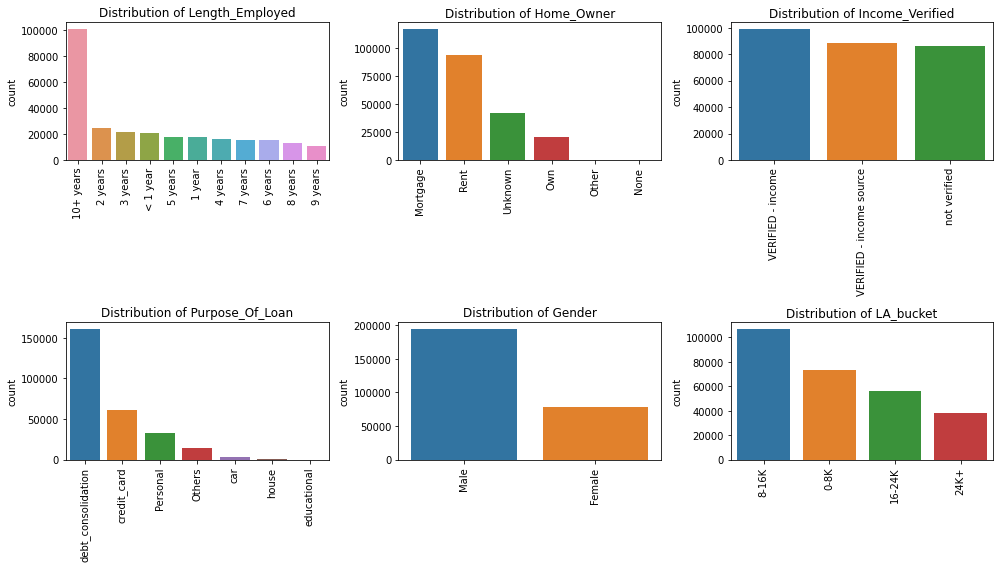

In [27]:

fig = plt.figure(1, (14, 8))

for i,cat in enumerate(combined[cat]):
    ax = plt.subplot(2,3,i+1)
    sns.countplot(combined[cat], order=combined[cat].value_counts().index)
    ax.set_xlabel("")
    ax.set_title(f'Distribution of {cat}')
    plt.tight_layout()
    plt.xticks(rotation=90)
    

plt.show()

In [0]:
nums = [x for x in combined.dtypes.index if combined.dtypes[x]!='object']
#Exclude :
nums = [x for x in nums if x not in ['Loan_ID','Interest_Rate','Loan_Amount_Requested']]

In [0]:
!pip install dython

In [0]:
#Correlation/Association
from dython.nominal import associations

cat = [x for x in combined.dtypes.index if combined.dtypes[x]=='object']
cat = [x for x in cat if x not in ['Loan_ID','TAG']]
associations(combined[(cat+nums+['Interest_Rate'])], theil_u=True, figsize=(10, 10))

In [0]:
combined.head()

In [0]:
df1=combined.drop(['Interest_Rate','TAG','Loan_ID'],axis=1)

# plt.figure(figsize=(20,10)) 
# sns.heatmap(df1.corr(), annot=True)
df1.corrwith(combined.Interest_Rate).plot.bar(
        figsize = (14, 8), title = "Correlation with Interest Rate", fontsize = 10,
        rot = 90, grid = True)

In [0]:
hhjh

In [0]:
train=combined[combined['TAG']=='TRAIN']
test=combined[combined['TAG']=='TEST']
# train=train.drop(['TAG','Inquiries_Last_6Mo','Total_Accounts','Gender','Number_Open_Accounts','Home_Owner','Length_Employed'],axis=1)
# test=test.drop(['TAG','Interest_Rate','Inquiries_Last_6Mo','Total_Accounts','Number_Open_Accounts','Gender','Home_Owner','Length_Employed'],axis=1)
# train=train.drop(['TAG','Inquiries_Last_6Mo','Gender','Number_Open_Accounts'],axis=1)
# test=test.drop(['TAG','Interest_Rate','Inquiries_Last_6Mo','Gender','Number_Open_Accounts'],axis=1)
train=train.drop(['TAG','Total_Accounts','Loan_Amount_Requested'],axis=1)
test=test.drop(['TAG','Interest_Rate','Total_Accounts','Loan_Amount_Requested'],axis=1)

In [0]:
train.shape,test.shape

In [0]:
!pip install catboost

In [0]:
from sklearn.model_selection import KFold
# Set up folds
K=7
kf = KFold(n_splits = K, random_state = 7, shuffle = True)
MAX_ROUNDS = 1000
t = False
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
X = train.drop(columns=['Loan_ID','Interest_Rate'],axis=1)
y = train['Interest_Rate']
X_test =test.drop(['Loan_ID'],axis=1)
y_valid_pred = 0*y
y_test_pred = 0
F1 = 0
result={}
#specifying categorical variables indexes
cat_columns = [x for x in X.dtypes.index if X.dtypes[x]=='object']
#fitting catboost classifier model
j=1
model = CatBoostClassifier(n_estimators=MAX_ROUNDS,task_type="GPU",verbose=False,learning_rate=0.07, leaf_estimation_iterations=1)
for i, (train_index, test_index) in enumerate(kf.split(train)):

#for train_index, test_index in skf.split(X, y):  
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", j)
    #print( "\nFold ", i)
    
    # Run model for this fold
    if t:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_valid, y_valid],cat_features=cat_columns,
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train,cat_features=cat_columns )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(f1_score(y_valid,pred,average='weighted'))
    F1+=f1_score(y_valid,pred,average='weighted')



    # Accumulate test set predictions
    y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    j+=1
results = y_test_pred / K  # Average test set predictions
print(F1/K)

In [0]:

d = pd.DataFrame()
for i in range(1, 6):
    d = pd.concat([d,pd.DataFrame(result[i])],axis=1)
d.columns=['1','2','3','4','5']
re = d.mode(axis=1)[0]
sub = pd.read_csv('sample_submission.csv')
sub.Interest_Rate = re


In [0]:
sub.to_csv('CAT_BOOST_final_v3.csv',index = False)

In [0]:
def f(train,test,classifier_filename,n):
    for i in n:
        
        print(classifier_filename[1][i])
        
    
        n_split = 8
        kf = KFold(n_splits=n_split, random_state=42, shuffle=True)
    
        y_valid_pred = 0 * target
        y_test_pred = 0


        for idx, (train_index, valid_index) in enumerate(kf.split(train)):
            y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
            X_train, X_valid = train.iloc[train_index,:], train.iloc[valid_index,:]
            X_train = sc_X.transform(X_train)
            X_valid = sc_X.transform(X_valid)
            '''_train = Pool(X_train, label=y_train)
            _valid = Pool(X_valid, label=y_valid)'''
            
            print( "\nFold ", idx)
            
            #for catboost
            if(classifier_filename[1][i]=="CatBoostClassifier.csv"):

                classifier_filename[0][i].fit(X_train,y_train,eval_set=(X_valid,y_valid),use_best_model=True,verbose=500)
            else:
                classifier_filename[0][i].fit(X_train,y_train)

        
            y_pred=classifier_filename[0][i].predict(X_valid)
        
            # Making the Confusion Matrix
            cm = confusion_matrix(y_valid, y_pred)
            print("cm=%s" %cm)
        
            #accuracy_score
            score=accuracy_score(y_valid,y_pred)
            print("score=%.4g"%score)
            #roc_score
            roc=roc_auc_score(y_valid,classifier_filename[0][i].predict_proba(X_valid)[:,1])
            print("roc=%.4g"%roc)
            #classification_report
            cr=classification_report(y_valid,y_pred)
            print("cr=%s"%cr)
        
            y_test_pred +=classifier_filename[0][i].predict_proba(test)[:,1]
            
        
    
        y_test_pred=y_test_pred/n_split
        '''for i in range(0,200000):
            y_test_pred_1.append(int(y_test_pred[i]/5))'''
    
        submission=pd.DataFrame()
        submission['ID_code']=test_id
        submission['target'] = y_test_pred
        submission.to_csv(classifier_filename[1][i],index=False)

'''
classifier=[]
from sklearn.linear_model import LogisticRegression
classifier.append(LogisticRegression(solver='sag',random_state = 0,n_jobs=1))

from sklearn.neighbors import KNeighborsClassifier
classifier.append(KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2,n_jobs=-1))

from sklearn.svm import SVC
classifier.append(SVC(kernel = 'linear', random_state = 0))

from sklearn.svm import SVC
classifier.append(SVC(kernel = 'rbf', random_state = 0))

from sklearn.naive_bayes import GaussianNB
classifier.append(GaussianNB())

from sklearn.tree import DecisionTreeClassifier
classifier.append(DecisionTreeClassifier(criterion = 'entropy', random_state = 0))

from sklearn.ensemble import RandomForestClassifier
classifier.append(RandomForestClassifier())

filename=["logistic_regression.csv","kneighbour.csv","kernel_linear.csv","kernwl_rbf.csv","gaussianNB.csv","decision_tree.csv","random_forest_tree.csv"]

classifier_filename=[]
classifier_filename.append(classifier)
classifier_filename.append(filename)


f(train,test,classifier_filename)'''

##boosting model

boosting_classifier_filename=[]
boosting_classifier=[]
filename=[]
#adaboost
from sklearn.ensemble import AdaBoostClassifier #For Classification
#from sklearn.ensemble import AdaBoostRegressor #For Regression
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier() 
boosting_classifier.append(AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=1.0))
filename.append("AdaBoostClassifier.csv")
#Above I have used decision tree as a base estimator, you can use any ML learner as base estimator if it ac# cepts sample weight 
#clf.fit(X_train,y_train)

#gradient boost
#
from sklearn.ensemble import GradientBoostingClassifier #For Classification
#from sklearn.ensemble import GradientBoostingRegressor #For Regression
boosting_classifier.append(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1))
#clf.fit(X_train, y_train)
filename.append("GradientBoostingClassifier.csv")
#XgBoost
#
from xgboost.sklearn import XGBClassifier
boosting_classifier.append(XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=3, min_child_weight=1, gamma=0,subsample=1,colsample_bytree=1,objective= 'binary:logistic',nthread=None,scale_pos_weight=1,seed=27))
filename.append("XGBClassifier.csv")


#lgbm
#not installed
#
'''  import lightgbm as lgb
train_data=lgb.Dataset(x_train,label=y_train)
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']
num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()
#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm
'''
           
           

#catboost
from catboost import CatBoostClassifier
boosting_classifier.append(CatBoostClassifier(loss_function="Logloss",eval_metric="AUC",task_type="GPU",learning_rate=0.008,iterations=14000,random_seed=42,od_type="Iter",depth=10,early_stopping_rounds=500))
filename.append("CatBoostClassifier.csv")


boosting_classifier_filename.append(boosting_classifier)
boosting_classifier_filename.append(filename)

f(train,test,boosting_classifier_filename,n=[3])